# **DEPENDENCIES**

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DATASET**

In [89]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

batch_size = 10000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Xtr, Ytr = next(iter(train_loader))
Xte, Yte = next(iter(test_loader))
Xtr = Xtr.view(Xtr.size(0), -1)
Xte = Xte.view(Xte.size(0), -1)

In [90]:
Xtr = Xtr.detach().numpy()
Xte = Xte.detach().numpy()
Ytr = Ytr.detach().numpy()
Yte = Yte.detach().numpy()
Ytr = np.eye(10)[Ytr]
Yte = np.eye(10)[Yte]

#### **Utils**

In [52]:
def plot_history(history, accu=False, title="Training vs Validation Loss"):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.set_style("darkgrid")
    sns.lineplot(
        x=range(1, len(history["loss"]) + 1),
        y=history["loss"],
        label="Training Loss",
    )
    sns.lineplot(
        x=range(1, len(history["val_loss"]) + 1),
        y=history["val_loss"],
        label="Validation Loss",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    if accu and "accuracy" in history and "val_accuracy" in history:
        plt.subplot(1, 2, 2)
        sns.set_style("darkgrid")
        sns.lineplot(
            x=range(1, len(history["accuracy"]) + 1),
            y=history["accuracy"],
            label="Training Accuracy",
        )
        sns.lineplot(
            x=range(1, len(history["val_accuracy"]) + 1),
            y=history["val_accuracy"],
            label="Validation Accuracy",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.suptitle(title)
    plt.show()


def plot_images(
    original_images, reconstructed_images, title="Original vs Reconstructed Images"
):
    fig, axes = plt.subplots(2, 10, figsize=(8, 2))
    fig.suptitle(title)

    for i in range(10):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.tight_layout()

    plt.show()

#### **Neural Network (scratch)**

In [50]:
class FeedForwardNet:
    def __init__(self, inp_units, hid_units, out_units):
        self.inp_units = inp_units
        self.hid_units = hid_units
        self.out_units = out_units

        # Parameters
        self.W1 = np.random.randn(self.inp_units, self.hid_units)
        self.b1 = np.random.randn(self.hid_units)
        self.W2 = np.random.randn(self.hid_units, self.out_units)
        self.b2 = np.random.randn(self.out_units)

    def _sigmoid(self, x):
        # Clip x values to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def _sigmoid_prime(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _mse(self, y, y_hat):
        return np.square(y - y_hat).mean()

    def _mse_prime(self, y, y_hat):
        return 2 * (y_hat - y) / y.size

    def _accuracy(self, y, y_hat, threshold=0.5):
        return np.sum(y == (y_hat > threshold)) / y.size

    def _forward_h(self, x):
        return self._sigmoid(np.dot(x, self.W1) + self.b1)

    def _forward_o(self, x):
        return self._sigmoid(np.dot(x, self.W2) + self.b2)

    def _forward(self, x):
        return self._forward_o(self._forward_h(x))

    def _backward_o(self, x, y, y_hat):
        dL_dz = self._mse_prime(y, y_hat) * self._sigmoid_prime(y_hat)
        dL_dW = np.dot(self._forward_h(x).T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        return dL_dW, dL_db, dL_dz

    def _backward_h(self, x, dL_dz):
        dL_dW = np.dot(
            x.T, np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x))
        )
        dL_db = np.sum(
            np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x)),
            axis=0,
        )
        return dL_dW, dL_db

    def _backward(self, x, y, y_hat, learning_rate):
        dL_dW2, dL_db2, dL_dz2 = self._backward_o(x, y, y_hat)
        dL_dW1, dL_db1 = self._backward_h(x, dL_dz2)
        self.W1 -= learning_rate * dL_dW1
        self.b1 -= learning_rate * dL_db1
        self.W2 -= learning_rate * dL_dW2
        self.b2 -= learning_rate * dL_db2

    def train(self, x, y, x_val, y_val, batch_size=16, epochs=10, learning_rate=1e-3):
        history = {
            "loss": [],
            "val_loss": [],
            "accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            for i in tqdm(range(0, x.shape[0], batch_size)):
                x_batch = x[i : i + batch_size]
                y_batch = y[i : i + batch_size]
                y_hat = self._forward(x_batch)
                self._backward(x_batch, y_batch, y_hat, learning_rate)
            y_hat = self._forward(x)
            y_val_hat = self._forward(x_val)
            history["loss"].append(self._mse(y, y_hat))
            history["val_loss"].append(self._mse(y_val, y_val_hat))
            history["accuracy"].append(self._accuracy(y, y_hat))
            history["val_accuracy"].append(self._accuracy(y_val, y_val_hat))
        return history

Epoch 1/25


100%|██████████| 625/625 [00:02<00:00, 232.32it/s]


Epoch 2/25


100%|██████████| 625/625 [00:02<00:00, 213.61it/s]


Epoch 3/25


100%|██████████| 625/625 [00:01<00:00, 406.53it/s]


Epoch 4/25


100%|██████████| 625/625 [00:01<00:00, 401.41it/s]


Epoch 5/25


100%|██████████| 625/625 [00:01<00:00, 411.06it/s]


Epoch 6/25


100%|██████████| 625/625 [00:01<00:00, 402.87it/s]


Epoch 7/25


100%|██████████| 625/625 [00:01<00:00, 388.72it/s]


Epoch 8/25


100%|██████████| 625/625 [00:03<00:00, 175.64it/s]


Epoch 9/25


100%|██████████| 625/625 [00:02<00:00, 219.90it/s]


Epoch 10/25


100%|██████████| 625/625 [00:01<00:00, 418.68it/s]


Epoch 11/25


100%|██████████| 625/625 [00:01<00:00, 417.06it/s]


Epoch 12/25


100%|██████████| 625/625 [00:01<00:00, 404.61it/s]


Epoch 13/25


100%|██████████| 625/625 [00:01<00:00, 410.73it/s]


Epoch 14/25


100%|██████████| 625/625 [00:01<00:00, 413.52it/s]


Epoch 15/25


100%|██████████| 625/625 [00:03<00:00, 201.91it/s]


Epoch 16/25


100%|██████████| 625/625 [00:02<00:00, 226.21it/s]


Epoch 17/25


100%|██████████| 625/625 [00:01<00:00, 414.37it/s]


Epoch 18/25


100%|██████████| 625/625 [00:01<00:00, 411.85it/s]


Epoch 19/25


100%|██████████| 625/625 [00:01<00:00, 409.05it/s]


Epoch 20/25


100%|██████████| 625/625 [00:01<00:00, 382.78it/s]


Epoch 21/25


100%|██████████| 625/625 [00:01<00:00, 414.63it/s]


Epoch 22/25


100%|██████████| 625/625 [00:02<00:00, 224.85it/s]


Epoch 23/25


100%|██████████| 625/625 [00:03<00:00, 204.65it/s]


Epoch 24/25


100%|██████████| 625/625 [00:01<00:00, 407.49it/s]


Epoch 25/25


100%|██████████| 625/625 [00:01<00:00, 390.58it/s]


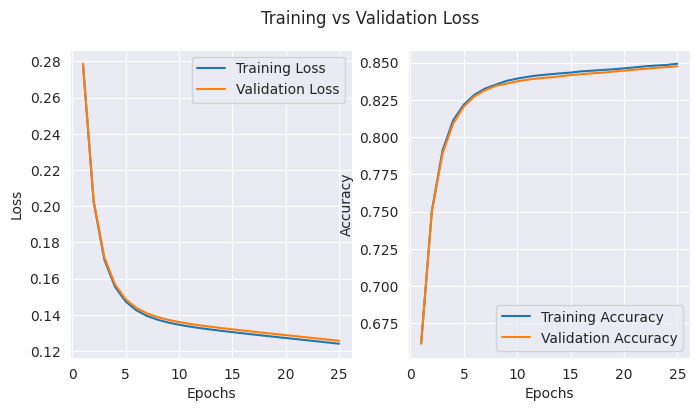

In [58]:
# Training
model = FeedForwardNet(784, 128, 10)
history = model.train(Xtr, Ytr, Xte, Yte, epochs=25)

# Plotting
plot_history(history, accu=True)

In [91]:
Xtr = torch.from_numpy(Xtr).float().to(device)
Xte = torch.from_numpy(Xte).float().to(device)
Ytr = torch.from_numpy(Ytr).float().to(device)
Yte = torch.from_numpy(Yte).float().to(device)

#### **Autoencoder**

In [68]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 28 * 28),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 1122.48it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 1107.36it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 1084.18it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 1077.06it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 1088.22it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 930.08it/s]


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 914.60it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 988.17it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 941.41it/s]


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 926.48it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 1000.36it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 1084.85it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 1102.93it/s]


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 1077.44it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 1084.48it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 1098.16it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 1089.43it/s]


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 1101.42it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 1079.86it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 1102.78it/s]


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 1098.47it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 1064.65it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 1080.33it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 1099.57it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 1062.52it/s]


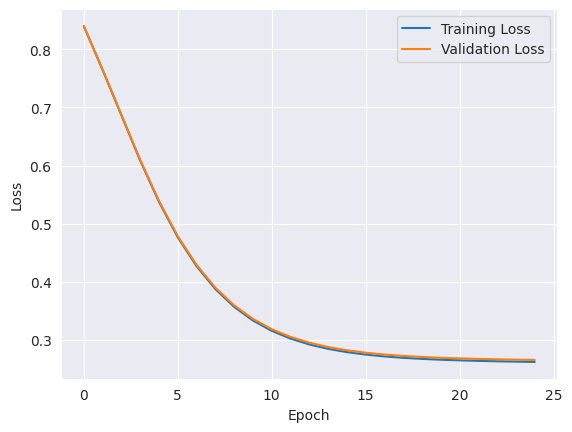

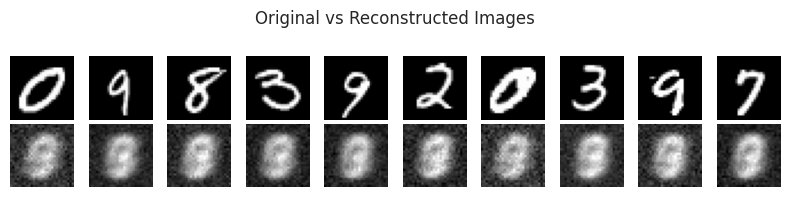

In [70]:
# Training
model_ae = Autoencoder()
model_ae = model_ae.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_ae.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Xtr[i : i + batch_size]
        x_enc = model_ae.encoder(x_batch)
        x_rec = model_ae.decoder(x_enc)
        loss_val = loss(x_rec, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    x_enc = model_ae.encoder(Xtr)
    x_rec = model_ae.decoder(x_enc)
    x_val_enc = model_ae.encoder(Xte)
    x_val_rec = model_ae.decoder(x_val_enc)
    history["loss"].append(loss(x_rec, Xtr).item())
    history["val_loss"].append(loss(x_val_rec, Xte).item())

# Plotting
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting
x_enc = model_ae.encoder(Xte)
x_rec = model_ae.decoder(x_enc).detach().cpu().numpy()
plot_images(Xte.detach().cpu().numpy(), x_rec)

#### **MLP with Sigmoid, MSE**

In [92]:
class MultiLayerPerceptron3(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron3, self).__init__()
        self.h = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
        )
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 911.63it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 1075.92it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 1049.11it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 1047.89it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 1071.31it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 1049.65it/s]


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 1046.15it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 1058.91it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 1018.59it/s]


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 1035.58it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 1015.79it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 1046.78it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 1083.40it/s]


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 1058.02it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 1081.63it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 1034.11it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 1060.95it/s]


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 891.03it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 928.96it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 918.13it/s]


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 887.53it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 878.12it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 1041.41it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 1068.35it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 1052.45it/s]


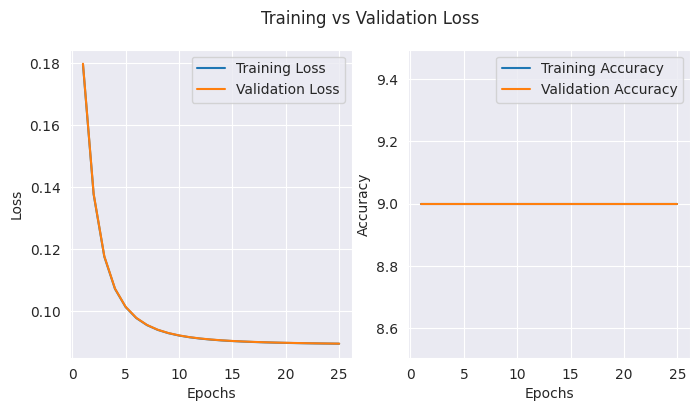

In [97]:
# Training
model_3 = MultiLayerPerceptron3()
model_3 = model_3.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = model_3.h(x_batch)
        y_hat = model_3.o(y_hat)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = model_3.h(Xtr)
    y_hat = model_3.o(y_hat)
    y_hat_val = model_3.h(Xte)
    y_hat_val = model_3.o(y_hat_val)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Plotting
plot_history(history, accu=True)

In [98]:
class MultiLayerPerceptron4(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron4, self).__init__()
        self.h = model_ae.encoder
        self.h[0].weight.requires_grad = False
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

Epoch 1/25


100%|██████████| 625/625 [00:00<00:00, 1062.29it/s]


Epoch 2/25


100%|██████████| 625/625 [00:00<00:00, 1079.59it/s]


Epoch 3/25


100%|██████████| 625/625 [00:00<00:00, 1129.78it/s]


Epoch 4/25


100%|██████████| 625/625 [00:00<00:00, 1072.40it/s]


Epoch 5/25


100%|██████████| 625/625 [00:00<00:00, 1099.58it/s]


Epoch 6/25


100%|██████████| 625/625 [00:00<00:00, 1099.95it/s]


Epoch 7/25


100%|██████████| 625/625 [00:00<00:00, 1112.00it/s]


Epoch 8/25


100%|██████████| 625/625 [00:00<00:00, 1098.60it/s]


Epoch 9/25


100%|██████████| 625/625 [00:00<00:00, 1071.14it/s]


Epoch 10/25


100%|██████████| 625/625 [00:00<00:00, 1111.63it/s]


Epoch 11/25


100%|██████████| 625/625 [00:00<00:00, 652.25it/s]


Epoch 12/25


100%|██████████| 625/625 [00:00<00:00, 900.02it/s]


Epoch 13/25


100%|██████████| 625/625 [00:00<00:00, 1082.50it/s]


Epoch 14/25


100%|██████████| 625/625 [00:00<00:00, 1055.53it/s]


Epoch 15/25


100%|██████████| 625/625 [00:00<00:00, 953.13it/s]


Epoch 16/25


100%|██████████| 625/625 [00:00<00:00, 922.00it/s]


Epoch 17/25


100%|██████████| 625/625 [00:00<00:00, 966.65it/s] 


Epoch 18/25


100%|██████████| 625/625 [00:00<00:00, 937.19it/s]


Epoch 19/25


100%|██████████| 625/625 [00:00<00:00, 955.55it/s]


Epoch 20/25


100%|██████████| 625/625 [00:00<00:00, 979.71it/s] 


Epoch 21/25


100%|██████████| 625/625 [00:00<00:00, 1091.58it/s]


Epoch 22/25


100%|██████████| 625/625 [00:00<00:00, 1076.47it/s]


Epoch 23/25


100%|██████████| 625/625 [00:00<00:00, 1093.80it/s]


Epoch 24/25


100%|██████████| 625/625 [00:00<00:00, 1105.04it/s]


Epoch 25/25


100%|██████████| 625/625 [00:00<00:00, 1070.50it/s]


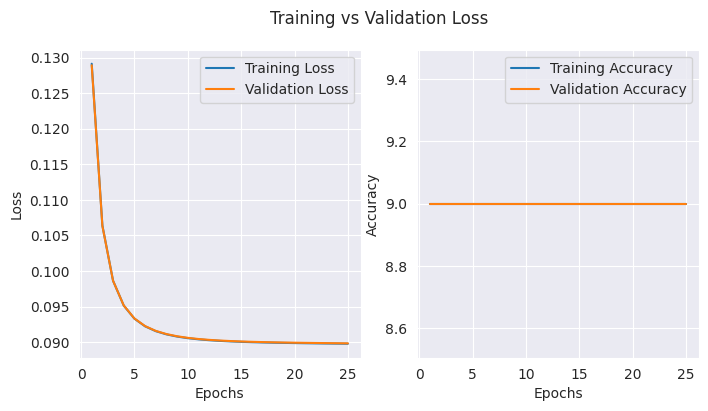

In [99]:
# Training
model_4 = MultiLayerPerceptron4()
model_4 = model_4.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = model_4.h(x_batch)
        y_hat = model_4.o(y_hat)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = model_4.h(Xtr)
    y_hat = model_4.o(y_hat)
    y_hat_val = model_4.h(Xte)
    y_hat_val = model_4.o(y_hat_val)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Plotting
plot_history(history, accu=True)

#### **LeNet**

In [100]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [102]:
# Training
lenet = LeNet5(10)
lenet = lenet.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.size(0), batch_size)):
        x_batch = Xtr[i : i + batch_size]
        y_batch = Ytr[i : i + batch_size]
        y_hat = lenet.forward(x_batch)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    y_hat = lenet.forrward(Xtr)
    y_hat_val = lenet.forward(Xte)
    history["loss"].append(loss(y_hat, Ytr).item())
    history["val_loss"].append(loss(y_hat_val, Yte).item())
    history["accuracy"].append(
        torch.sum(Ytr == (y_hat > 0.5)).item() / Ytr.size(0)
    )
    history["val_accuracy"].append(
        torch.sum(Yte == (y_hat_val > 0.5)).item() / Yte.size(0)
    )

# Plotting
plot_history(history, accu=True)

Epoch 1/25


  0%|          | 0/625 [00:00<?, ?it/s]


RuntimeError: ignored

<!-- Implement a 3 layer MLP using PyTorch use sigmoid func;on as
ac;va;on in all layers and ini;alize the first 2-layers with pretrained
weights as per the deep belief network using autoencoders then fine
tune it using MSE and SGD with autograd. Use appropriate learning
rate or a momentum on weights. Compare the results of the III and IV
for training vs valida;on losses and accuracies. Plot the train and
valida;on curves in a single figure. -->